# CS 136 day05 Lab: Univariate Gaussian distributions

## Outline

* **Part 1: Univariate Gaussian Distribution Basics**
* * Learn to sample from a univariate Gaussian

* **Part 2: ML Estimators and biased vs unbiased**
* * Simulate finite sample from true model, then estimate from that sample. Repeat many times.

* **Part 3: Properties of the univariate Gaussian**
* * Visualize linear transformations of Gaussian samples
* * Visualize sums of Gaussian samples
* * Visualize products of Gaussian samples
* * Learn to evaluate PDF of a univariate Gaussian and plot it alongside a histogram

## Skills 

* To draw samples:
* * [`scipy.stats.norm(loc=..., scale=...).rvs(size=(nrows,ncols), random_state=SEED)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)
* * OR [`np.random.normal(loc=..., scale=...)`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)
* To evaluate the PDF:
* * Evaluate pdf with `scipy.stats.norm(loc=..., scale=...).pdf(values)`
* * Evaluate logpdf with `logpdf` instead of `pdf`


## Takeaways

* Linear transforms of Gaussian variables are also Gaussian distributed
* The sum of Gaussian variables is also Gaussian distributed
* The product of Gaussian variables is *not* Gaussian distributed


In [1]:
import numpy as np
import pandas as pd
import scipy.stats

In [2]:
np.set_printoptions(precision=3, suppress=False)

In [3]:
pd.options.display.float_format = '{:,.3g}'.format  # show 3 digits of precision

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

# Part 1: Univariate Gaussian basics

## Univariate Gaussian background



#### Random Variable: Scalar data $x \in \mathbb{R}$

This is a scalar real value.

#### Parameters: Location $\mu$ and scale $\sigma$

* Location or "mean" is just any real value: $\mu \in \mathbb{R}$
* Scale or standard-deviation $\sigma$ must be a positive value: $\sigma > 0$

We can also call *square* of the  "scale" parameter the *variance*: $\sigma^2$

#### Formal definition of PDF: 

\begin{align}
\text{NormPDF}\left( x | \mu, \sigma^2 \right) 
    = c(\mu, \sigma) \cdot e^{-\frac{1}{2} \frac{1}{\sigma^2} (x - \mu)^2 }
\end{align}

with normalizing "constant" (a term constant wrt our random variable $x$):

$$
c(\mu, \sigma) = \frac{1}{(2\pi)^{1/2}} \frac{1}{\sigma}
$$

Remember, this normalizing term ensures that this is a valid PDF (the integral of $p(x|\mu, \sigma^2)$ over the domain of $x$ equals 1 as required.

##  Sampling from the "standard" univariate Gaussian

It is common to think about the Gaussian with zero mean and variance one.
Call this the "standard" normal or "standard" Gaussian.

We can use `np.random.randn` to sample from the standard normal

Set our random state so things are reproducible.

In [5]:
prng = np.random.RandomState(11)

Draw several samples from the *standard* Normal (*standard* means zero mean and unit variance)

In [6]:
prng.randn()

1.7494547413051793

In [7]:
prng.randn()

-0.28607299681629417

In [8]:
prng.randn()

-0.4845651322211443

Draw 1000 samples and plot the histogram

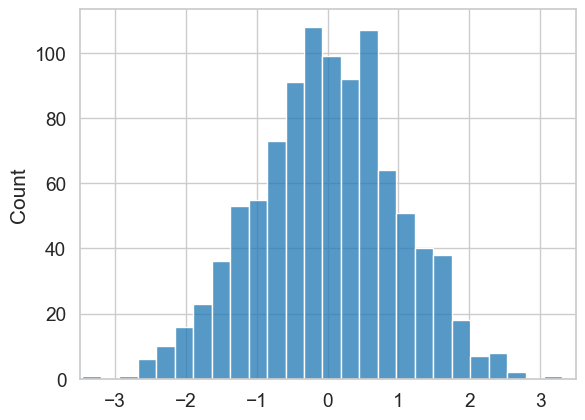

In [9]:
N = 1000
x_N = prng.randn(N)
sns.histplot(x_N);
plt.xlim([-3.5, 3.5]);

Do it again.

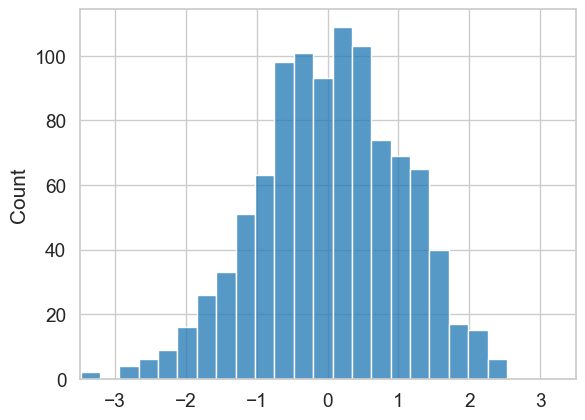

In [10]:
N = 1000
x_N = prng.randn(N)
sns.histplot(x_N);
plt.xlim([-3.5, 3.5]);

##  Sampling from the *general* univariate Gaussian

Here, we'll assume that the mean and variance of the Gaussian are given

In [11]:
mu = 11.22
sigma = 3.0

In [12]:
prng.normal(loc=mu, scale=sigma)

14.066253367334497

In [13]:
prng.normal(loc=mu, scale=sigma)

8.297169994971785

## Exercise 1a: Write code to plot a histogram of samples with $\mu = -1, \sigma = 3$

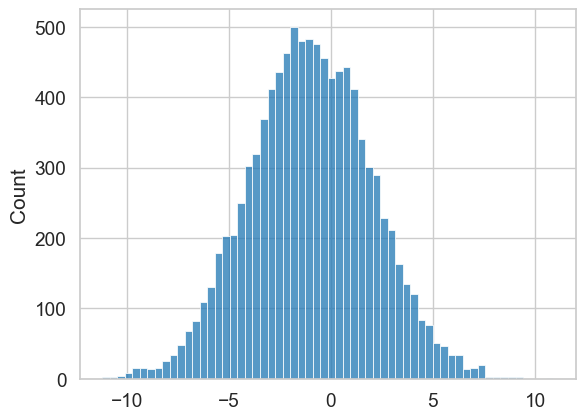

In [14]:
N = 10000
# TODO draw samples (hint: use prng.normal with provided loc and scale)
x_N = prng.normal(loc = -1, scale = 3, size = N)
# TODO plot histogram (hint: see lines above for calls to sns.histplot)
sns.histplot(x_N);

## Exercise 1b: Write code to plot a histogram of samples with $\mu = -5, \sigma = 0.2$

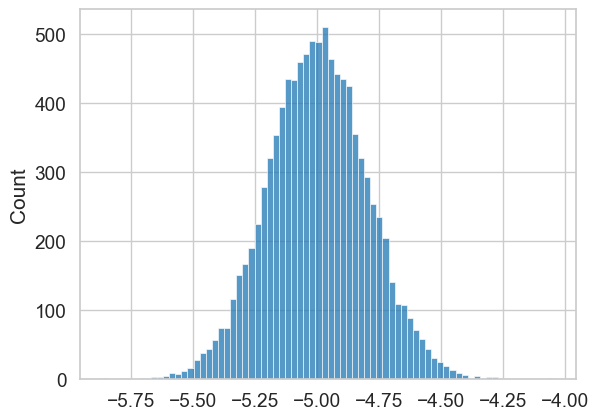

In [15]:
N = 10000
# TODO draw samples (hint: use prng.normal with provided loc and scale)
x_N = prng.normal(loc = -5, scale = 0.2, size = N)
# TODO plot histogram (hint: see lines above for calls to sns.histplot)
sns.histplot(x_N);

## Discussion 1c: Can you use the plots above to come up with reasonable rules for the "high density" regions of the univariate normal?

* A "super-majority" of samples (say 2/3 or ~67%) will occur between $\mu - a$ and $\mu + a$
* Almost all samples (say ~99%) will occur between $\mu - b$ and $\mu + b$

How should we pick $a$ and $b$? Can they be constants? Or should they depend on $\mu$ or $\sigma$?

## Exercise 1d: Try out your rules

In [22]:
mu = 101.0
sigma = 15.0
a = 0.0 # TODO fix me
b = 0.0 # TODO fix me

N = 10000
x_N = prng.normal(loc=mu, scale=sigma, size=N)

n_match_for_a = np.sum(np.logical_and(x_N >= mu - a, x_N <= mu + a))
n_match_for_b = np.sum(np.logical_and(x_N >= mu - b, x_N <= mu + b))

print("%.2f samples occur between mu - %.2f and mu + %.2f" % (n_match_for_a/N, a, a))
print("%.2f samples occur between mu - %.2f and mu + %.2f" % (n_match_for_b/N, b, b))

0.00 samples occur between mu - 0.00 and mu + 0.00
0.00 samples occur between mu - 0.00 and mu + 0.00


# Part 2: Unbiased vs. Biased estimation of parameters

In pre-recorded videos, we developed estimators for parameters $\mu, \sigma$ using the *maximum likelihood* principle, which solves the estimation problem

\begin{align}
\hat{\mu}, \hat{\sigma} \gets \arg\max_{\mu \in \mathbb{R}, \sigma \in \mathbb{R}_+} \sum_{n=1}^N \log \text{NormPDF}(x_n | \mu, \sigma)
\end{align}

By taking gradients, setting to zero, and solving for the parameters of interest, we get the following estimators:

\begin{align}
\hat{\mu} &= \frac{1}{N} \sum_{n=1}^N x_n, \qquad 
\\
\hat{\sigma}^2 &= \frac{1}{N} \sum_{n=1}^N (x_n - \hat{\mu} )^2
\end{align}

We further learned that:
  
* the ML-estimator for the mean is *unbiased*
* the ML-estimator for the variance is *biased*

Here, we're gonna work on *demonstrating* this bias (or lack there of) via simulation.

## Exercise 2a: Implement the ML estimation formulas in code

In [17]:
def calc_ml_estimates_for_mean_and_variance(x_N):
    ''' Compute the ML estimators for Gaussian parameters given N observed data
    
    Args
    ----
    x_N : 1D array, shape (n_examples,) = (N,)
        N iid observations to be modeled as draws from a univariate Gaussian
    
    Returns
    -------
    mu_hat : float
    sigma_squared_hat : float, must be positive
    '''
    mu_hat = 0.0 # TODO fix me
    sigma_squared_hat = 1.0 # TODO fix me
    return mu_hat, sigma_squared_hat

## Exercise 2b: Implement simulations that repeatedly generate data from true model and then estimate parameters 

In [18]:
def run_many_simulations(n_trials=1000, N=10, mu_true=1.0, sigma_squared_true=1.0):
    ''' Produce estimates of parameters for many trials of a toy data experiment
    
    Each trial will:
    * Draw N samples of x_n ~ Normal(mean=mu_true, variance=sigma_squared_true)
    * Compute ML estimates using these samples
    
    Returns
    -------
    mu_hat_R : 1D array, shape (n_trials,) = (R,)
        Contains mu_hat estimate for each trial
    sigma_squared_hat_R : 1D array, shape (n_trials,) = (R,)
        Contains sigma_squared_hat estimate for each trial
    '''
    mu_hat_list = list()
    sigma_squared_hat_list = list()
    for trial in range(n_trials):
        x_N = np.zeros(N) # TODO draw N samples of x from a Gaussian with mu_true and sigma_squared_true
        assert x_N.shape == (N,)

        # Use your function from 2a to get estimates of the parameters
        mu_hat, sigma_squared_hat = calc_ml_estimates_for_mean_and_variance(x_N)

        # Record these estimates in a big list
        mu_hat_list.append(mu_hat)
        sigma_squared_hat_list.append(sigma_squared_hat)
    return np.asarray(mu_hat_list), np.asarray(sigma_squared_hat_list)
        

## Exercise 2c: Run simulations with R=200 trials and N=10 samples

We'll visualize the *distribution* of our estimator across trials.

We'll also look at how well the *average result* of these trials matches our *true* parameter.

Run the code below. No need to edit it.

In [19]:
mu_true = 30.0;             # Keep this at 30
sigma_squared_true = 10.0;  # Keep this at 10
N = 10
R = 200

mu_hat_R, sigma_squared_hat_R = run_many_simulations(
    n_trials=R, N=N, mu_true=mu_true, sigma_squared_true=sigma_squared_true)

### Visualize true $\mu$ and estimates from many trials

Just run the code below to produce a visual. You don't need to edit it.

Empirical average value of \hat{\mu} = 0.00 over 200 trials


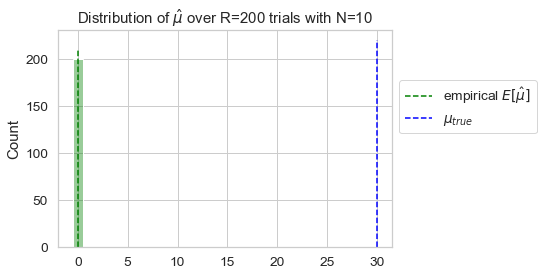

In [20]:
mu_hat_mean = np.mean(mu_hat_R);
print("Empirical average value of \hat{\mu} = %.2f over %d trials" % (mu_hat_mean, R))

# Plot histogram of mu_hats across all R trials
sns.histplot(mu_hat_R, color='g', alpha=0.4);

# Plot "true" mu and "mean" mu as vertical lines
plt.plot(mu_hat_mean * np.ones(2), np.asarray([0, plt.gca().get_ylim()[1]]), 'g--', label='empirical $E[\hat{\mu}]$');
plt.plot(mu_true * np.ones(2), np.asarray([0, plt.gca().get_ylim()[1]]), 'b--', label='$\mu_{true}$');
plt.legend(bbox_to_anchor=(1.0, 0.8));

plt.title("Distribution of $\hat{\mu}$ over R=%d trials with N=%d" % (R, N));

### Compare true $\sigma^2$ and estimates from many trials

Just run the code below to produce a visual. You don't need to edit it.

Empirical average value of \hat{\sigma}^2 = 1.00


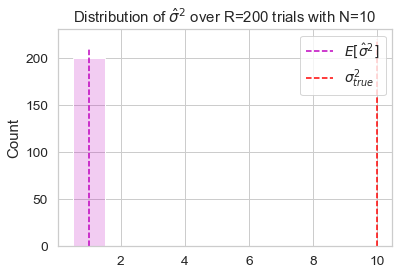

In [21]:
sigma_squared_hat_mean = np.mean(sigma_squared_hat_R);
print("Empirical average value of \hat{\sigma}^2 = %.2f" % sigma_squared_hat_mean)

sns.histplot(sigma_squared_hat_R, color='m', alpha=0.2);

# Plot "true" sigma and "mean" sigma_hat as vertical lines
plt.plot(sigma_squared_hat_mean * np.ones(2), np.asarray([0, plt.gca().get_ylim()[1]]), 'm--', label='$E[ \hat{\sigma}^2]$');
plt.plot(sigma_squared_true * np.ones(2), np.asarray([0, plt.gca().get_ylim()[1]]), 'r--', label='$\sigma^2_{true}$');
plt.legend(loc='upper right');

plt.title("Distribution of $\hat{\sigma}^2$ over R=%d trials with N=%d" % (R, N));

## Exercise 2d: Repeat the above with $R=10000$ trials (still keep $N=10$)



TODO copy code here and edit as needed.

## Discussion 2e: Do you see the bias for sigma? Do you see a "lack" of bias for mu?


TODO discuss. What visually in the plots above reveals "bias"? Do the patterns you see change with many trials?

## Discussion 2f: Does the amount of bias agree with derivations?

Remember, we suggested that:
    
$$
\mathbb{E}[ \hat{\sigma}^2 ] = \frac{N-1}{N} \sigma_{\text{true}}
$$


TODO discuss

# Part 3: Visualizing transformations of Gaussians

### Exercise 3a: Linear transformations of Gaussians

* 1) Drawn 10000 samples of $X$ a standard Normal.
* 2) Transform each $X$ into $Y$, using linear transform $Y \gets 3 X + 2$
* 3) Draw the histograms of the resulting distributions
* 4a) Add a PDF plot for ML-estimated parameters using the samples of $X$
* 4b) Add a PDF plot for ML-estimated parameters using the samples of $Y$

Note that there are coding TODOs only for 1 and 4



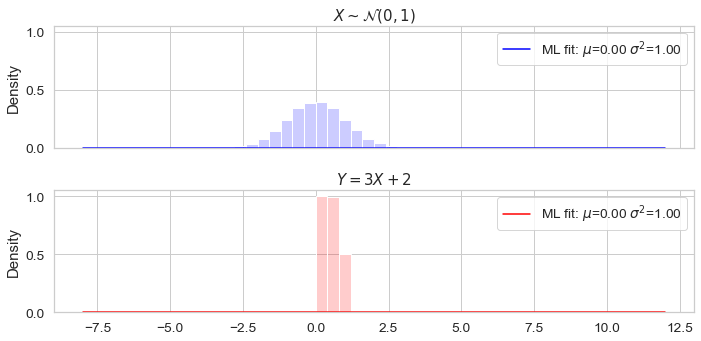

In [22]:
# STEP 1: Draw samples 
x_N = prng.randn(10000)

# STEP 2: Apply linear transform: Y = 3 * X + 2
y_N = prng.rand(10000) # TODO replace with transform

# STEP 3: Draw histograms
fig, axgrid = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10, 5))
sns.histplot(x_N, color='b', alpha=0.2, ax=axgrid[0], bins=np.linspace(-8, 12, 51), stat='density');
sns.histplot(y_N, color='r', alpha=0.2, ax=axgrid[1], bins=np.linspace(-8, 12, 51), stat='density');

# STEP 4a: Compute ML-estimates of parameters for X
mu_hat, sigma_squared_hat = calc_ml_estimates_for_mean_and_variance(x_N)
xgrid_G = np.linspace(-8, 12, 301);
pdfgrid_G = np.zeros(xgrid_G.size) # TODO call scipy.stats.norm's pdf function to get the pdf
axgrid[0].plot(xgrid_G, pdfgrid_G, 'b-', label="ML fit: $\mu$=%.2f $\sigma^2$=%.2f" % (mu_hat, sigma_squared_hat));
axgrid[0].legend(loc='upper right');
axgrid[0].set_title('$X \sim \mathcal{N}(0, 1)$')

# STEP 4b: Compute ML-estimates of parameters for Y
mu_hat, sigma_squared_hat = calc_ml_estimates_for_mean_and_variance(y_N)
ygrid_G = np.linspace(-8, 12, 301);
pdfgrid_G = np.zeros(ygrid_G.size) # TODO call scipy.stats.norm's pdf function to get the pdf
axgrid[1].plot(ygrid_G, pdfgrid_G, 'r-', label="ML fit: $\mu$=%.2f $\sigma^2$=%.2f" % (mu_hat, sigma_squared_hat));
axgrid[1].legend(loc='upper right');
axgrid[1].set_title('$Y = 3 X + 2$');

plt.tight_layout();

## Discussion 3b: Does Y appear to be Gaussian distributed?

TODO discuss. What clues did you use?

## Exercise 3c: Sums of Gaussian random variables

* 1a) Draw 10000 samples of $X$ from a standard Normal.
* 1b) Draw 10000 samples of $Y$ from a standard Normal.

* 2) Apply a sum transform: $Z = X+ Y$
* 3) Draw the histograms of the resulting distributions

* 4) Add a PDF plot for ML-estimated parameters using the samples of $Z$

Note that there are coding TODOs only for 1 and 4



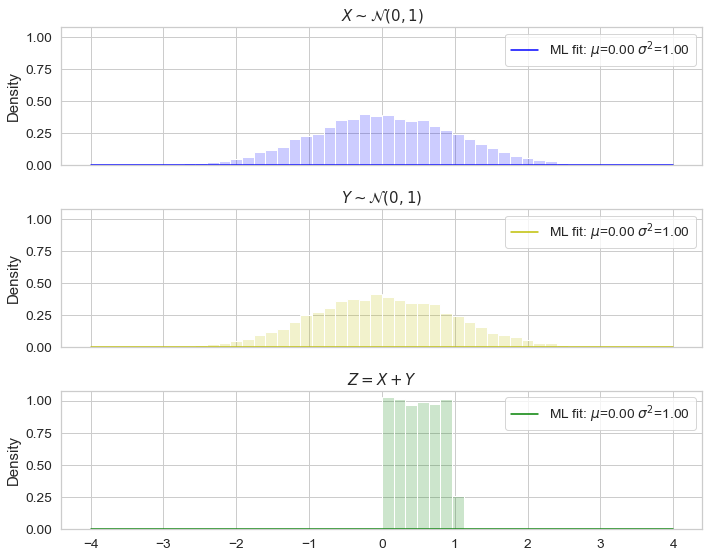

In [23]:
# STEP 1: Draw samples 
x_N = prng.randn(10000)
y_N = prng.randn(10000)

# STEP 2: Apply sum transform: Z = X + Y
z_N = prng.rand(10000) # TODO replace with transform
               
# STEP 3: Draw histograms
xmin = -4
xmax = +4
fig, axgrid = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10, 8))
sns.histplot(x_N, color='b', alpha=0.2, ax=axgrid[0], bins=np.linspace(xmin, xmax, 51), stat='density');
sns.histplot(y_N, color='y', alpha=0.2, ax=axgrid[1], bins=np.linspace(xmin, xmax, 51), stat='density');
sns.histplot(z_N, color='g', alpha=0.2, ax=axgrid[2], bins=np.linspace(xmin, xmax, 51), stat='density');

# STEP 4a: Compute ML-estimates of parameters for X
mu_hat, sigma_squared_hat = calc_ml_estimates_for_mean_and_variance(x_N)
xgrid_G = np.linspace(xmin, xmax, 301);
pdfgrid_G = np.zeros(ygrid_G.size) # TODO call scipy.stats.norm's pdf function to get the pdf
axgrid[0].plot(xgrid_G, pdfgrid_G, 'b-', label="ML fit: $\mu$=%.2f $\sigma^2$=%.2f" % (mu_hat, sigma_squared_hat));
axgrid[0].legend(loc='upper right');
axgrid[0].set_title('$X \sim \mathcal{N}(0, 1)$')

# STEP 4b: Compute ML-estimates of parameters for Y
mu_hat, sigma_squared_hat = calc_ml_estimates_for_mean_and_variance(y_N)
ygrid_G = np.linspace(xmin, xmax, 301);
pdfgrid_G = np.zeros(ygrid_G.size) # TODO call scipy.stats.norm's pdf function to get the pdf
axgrid[1].plot(ygrid_G, pdfgrid_G, 'y-', label="ML fit: $\mu$=%.2f $\sigma^2$=%.2f" % (mu_hat, sigma_squared_hat));
axgrid[1].legend(loc='upper right');
axgrid[1].set_title('$Y \sim \mathcal{N}(0, 1)$');

# STEP 4b: Compute ML-estimates of parameters for Z
mu_hat, sigma_squared_hat = calc_ml_estimates_for_mean_and_variance(z_N)
zgrid_G = np.linspace(xmin, xmax, 301);
pdfgrid_G = np.zeros(ygrid_G.size) # TODO call scipy.stats.norm's pdf function to get the pdf
axgrid[2].plot(zgrid_G, pdfgrid_G, 'g-', label="ML fit: $\mu$=%.2f $\sigma^2$=%.2f" % (mu_hat, sigma_squared_hat));
axgrid[2].legend(loc='upper right');
axgrid[2].set_title('$Z = X + Y$');
plt.tight_layout();

## Discussion 3d: Does Z = X + Y above appear to be Gaussian distributed?

In [24]:
# TODO discuss!

## Exercise 3e: Products of Gaussian random variables

* 1a) Draw 10000 samples of $X$ from a standard Normal.
* 1b) Draw 10000 samples of $Y$ from a standard Normal.

* 2) Apply a *product* transform: $Z = X * Y$
* 3) Draw the histograms of the resulting distributions

* 4) Add a PDF plot for ML-estimated parameters using the samples of $Z$




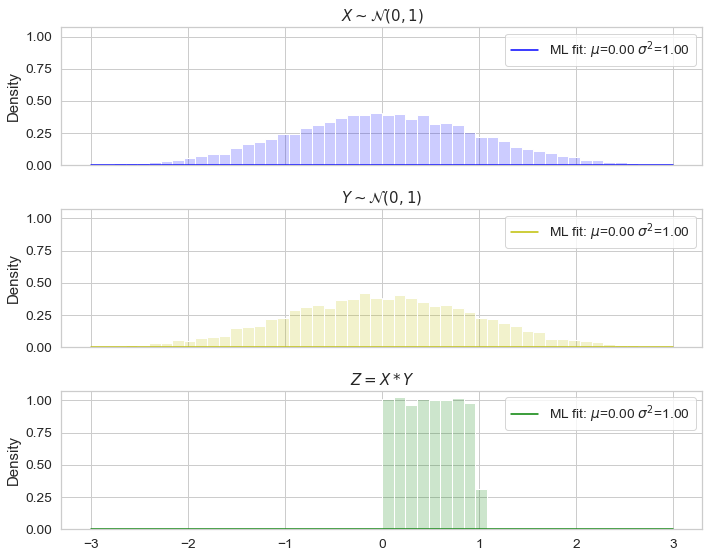

In [25]:
# STEP 1: Draw samples 
x_N = prng.randn(10000)
y_N = prng.randn(10000)

# STEP 2: Apply product transform: Z = X * Y
z_N = prng.rand(10000) # TODO replace with transform

# STEP 3: Draw histograms
xmin = -3
xmax = +3
fig, axgrid = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10, 8))
sns.histplot(x_N, color='b', alpha=0.2, ax=axgrid[0], bins=np.linspace(xmin, xmax, 51), stat='density');
sns.histplot(y_N, color='y', alpha=0.2, ax=axgrid[1], bins=np.linspace(xmin, xmax, 51), stat='density');
sns.histplot(z_N, color='g', alpha=0.2, ax=axgrid[2], bins=np.linspace(xmin, xmax, 51), stat='density');

# STEP 4a: Compute ML-estimates of parameters for X
mu_hat, sigma_squared_hat = calc_ml_estimates_for_mean_and_variance(x_N)
xgrid_G = np.linspace(xmin, xmax, 301);
pdfgrid_G = np.zeros(xgrid_G.size) # TODO compute PDF
axgrid[0].plot(xgrid_G, pdfgrid_G, 'b-', label="ML fit: $\mu$=%.2f $\sigma^2$=%.2f" % (mu_hat, sigma_squared_hat));
axgrid[0].legend(loc='upper right');
axgrid[0].set_title('$X \sim \mathcal{N}(0, 1)$')

# STEP 4b: Compute ML-estimates of parameters for Y
mu_hat, sigma_squared_hat = calc_ml_estimates_for_mean_and_variance(y_N)
ygrid_G = np.linspace(xmin, xmax, 301);
pdfgrid_G = np.zeros(xgrid_G.size) # TODO compute PDF
axgrid[1].plot(ygrid_G, pdfgrid_G, 'y-', label="ML fit: $\mu$=%.2f $\sigma^2$=%.2f" % (mu_hat, sigma_squared_hat));
axgrid[1].legend(loc='upper right');
axgrid[1].set_title('$Y \sim \mathcal{N}(0, 1)$');

# STEP 4b: Compute ML-estimates of parameters for Z
mu_hat, sigma_squared_hat = calc_ml_estimates_for_mean_and_variance(z_N)
zgrid_G = np.linspace(xmin, xmax, 301);
pdfgrid_G = np.zeros(xgrid_G.size) # TODO compute PDF
axgrid[2].plot(zgrid_G, pdfgrid_G, 'g-', label="ML fit: $\mu$=%.2f $\sigma^2$=%.2f" % (mu_hat, sigma_squared_hat));
axgrid[2].legend(loc='upper right');
axgrid[2].set_title('$Z = X * Y$');
plt.tight_layout();

## Discussion 3f: Does Z = X * Y above appear to be Gaussian distributed?

TODO discuss! 